## Dataset

- training_data.csv: for training and metrics

- prediction_data.csv:  for prediction 

Data Description:

	Features are computed from a digitized image of a fine needle
	aspirate (FNA) of a breast mass.  They describe
	characteristics of the cell nuclei present in the image.
	A few of the images can be found at
	http://www.cs.wisc.edu/~street/images/

Number of instances: 569 

Number of attributes: 32 (ID, diagnosis, 30 real-valued input features)

Attribute information:

1) ID number

2) Diagnosis (M = malignant, B = benign)

3-32) Ten real-valued features are computed for each cell nucleus:

	a) radius (mean of distances from center to points on the perimeter)
	b) texture (standard deviation of gray-scale values)
	c) perimeter
	d) area
	e) smoothness (local variation in radius lengths)
	f) compactness (perimeter^2 / area - 1.0)
	g) concavity (severity of concave portions of the contour)
	h) concave points (number of concave portions of the contour)
	i) symmetry 
	j) fractal dimension ("coastline approximation" - 1)

The mean, standard error, and "worst" or largest (mean of the three
largest values) of these features were computed for each image,
resulting in 30 features.  For instance, field 3 is Mean Radius, field
13 is Radius SE, field 23 is Worst Radius.

## Objective
1. Train classification models to predict whether a given breast cancer sample is malignant (M) or benign (B).
  - Use data from training_data.csv for training.

2. Determine which model  performs the best:
  - get the model score
  - use classification_report
  - use confusion_matrix
  - state which model is the best performing one and why

3. use the model to predict the unseen data
  - Use data from prediction_data.csv
  - Get a prediction from your best model, print out the prediction (malignant or benign).


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score
import pickle
import numpy as np

%matplotlib inline

## Train Classification Models

Using classification models to predict whether a given breast cancer sample is malignant (M) or benign (B). 


### A. Load and Clean data

#### Load data

In [2]:
df = pd.read_csv('training_data.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 565 entries, 0 to 564
Data columns (total 32 columns):
id                         565 non-null int64
diagnosis                  565 non-null object
radius_mean                563 non-null float64
texture_mean               565 non-null float64
perimeter_mean             565 non-null float64
area_mean                  565 non-null float64
smoothness_mean            565 non-null float64
compactness_mean           565 non-null float64
concavity_mean             562 non-null float64
concave points_mean        565 non-null float64
symmetry_mean              565 non-null float64
fractal_dimension_mean     565 non-null float64
radius_se                  565 non-null float64
texture_se                 565 non-null float64
perimeter_se               565 non-null float64
area_se                    565 non-null float64
smoothness_se              565 non-null float64
compactness_se             565 non-null float64
concavity_se               565 non

#### Inspect for NaNs and clean (if any)

In [3]:
#df.isna().any()
print(" Before removing NaN rows: ", df.shape)

var = df.columns[df.isna().any()].tolist()
for c in var:    
#    print ( c, ' contains ', df[c].isnull().sum(), ' NaN' )
#    print ( df[df[c].isnull()])
    df = df[~df[c].isnull()]

print(" After removing NaN rows: ", df.shape)

#print('Find Unique values')
#for c in df.columns:
#  print ( c, ' #unique values: ', len(df[c].unique()))

del df['id']
print('Removed id.  New shape:', df.shape)


 Before removing NaN rows:  (565, 32)
 After removing NaN rows:  (560, 32)
Removed id.  New shape: (560, 31)


#### Inspect for columns to encode, and perform encoding (if any)

In [4]:
print(df.dtypes)
diagnosis_encoder = LabelEncoder()
df['diagnosis'] = diagnosis_encoder.fit_transform(df['diagnosis'])
#print(df.head())

diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst            float64
concave points_worst

### B. Explore data

- Inspect the correlations to explore how features are correlated with target
- Scale and visualize using PCA

#### Inspect correlations

In [5]:
df.corr()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
diagnosis,1.000000,0.727659,0.408147,0.740238,0.706321,0.356906,0.596987,0.696039,0.776726,0.328284,...,0.775655,0.450648,0.781654,0.732372,0.426182,0.597127,0.661694,0.795032,0.420791,0.323779
radius_mean,0.727659,1.000000,0.317945,0.997860,0.987341,0.158544,0.504657,0.675073,0.821141,0.140248,...,0.969172,0.289459,0.964888,0.940757,0.115919,0.414935,0.525058,0.743590,0.163491,0.002461
texture_mean,0.408147,0.317945,1.000000,0.323537,0.314458,-0.021826,0.229824,0.294447,0.286749,0.067615,...,0.347256,0.910137,0.351563,0.338286,0.085991,0.273811,0.296037,0.291714,0.106263,0.117489
perimeter_mean,0.740238,0.997860,0.323537,1.000000,0.986584,0.195404,0.555440,0.714379,0.849692,0.175301,...,0.969158,0.295213,0.970108,0.941365,0.146568,0.456831,0.561729,0.770470,0.188168,0.045858
area_mean,0.706321,0.987341,0.314458,0.986584,1.000000,0.168177,0.498305,0.685379,0.822456,0.144995,...,0.962202,0.279394,0.958802,0.958735,0.121792,0.393062,0.511844,0.722130,0.143151,0.000899
smoothness_mean,0.356906,0.158544,-0.021826,0.195404,0.168177,1.000000,0.656534,0.515705,0.548507,0.553360,...,0.204545,0.035456,0.229896,0.200950,0.806226,0.466492,0.426896,0.496087,0.391570,0.496464
compactness_mean,0.596987,0.504657,0.229824,0.555440,0.498305,0.656534,1.000000,0.880702,0.830812,0.596544,...,0.534965,0.239024,0.589022,0.510973,0.562534,0.862628,0.811377,0.813841,0.504699,0.680955
concavity_mean,0.696039,0.675073,0.294447,0.714379,0.685379,0.515705,0.880702,1.000000,0.920637,0.492508,...,0.686992,0.289888,0.727565,0.676233,0.445424,0.751671,0.882758,0.860507,0.403677,0.508468
concave points_mean,0.776726,0.821141,0.286749,0.849692,0.822456,0.548507,0.830812,0.920637,1.000000,0.455430,...,0.829300,0.284113,0.854813,0.809565,0.451533,0.667460,0.750266,0.910827,0.371978,0.364276
symmetry_mean,0.328284,0.140248,0.067615,0.175301,0.144995,0.553360,0.596544,0.492508,0.455430,1.000000,...,0.179304,0.085512,0.211959,0.172341,0.422503,0.466479,0.425769,0.424291,0.697729,0.432553


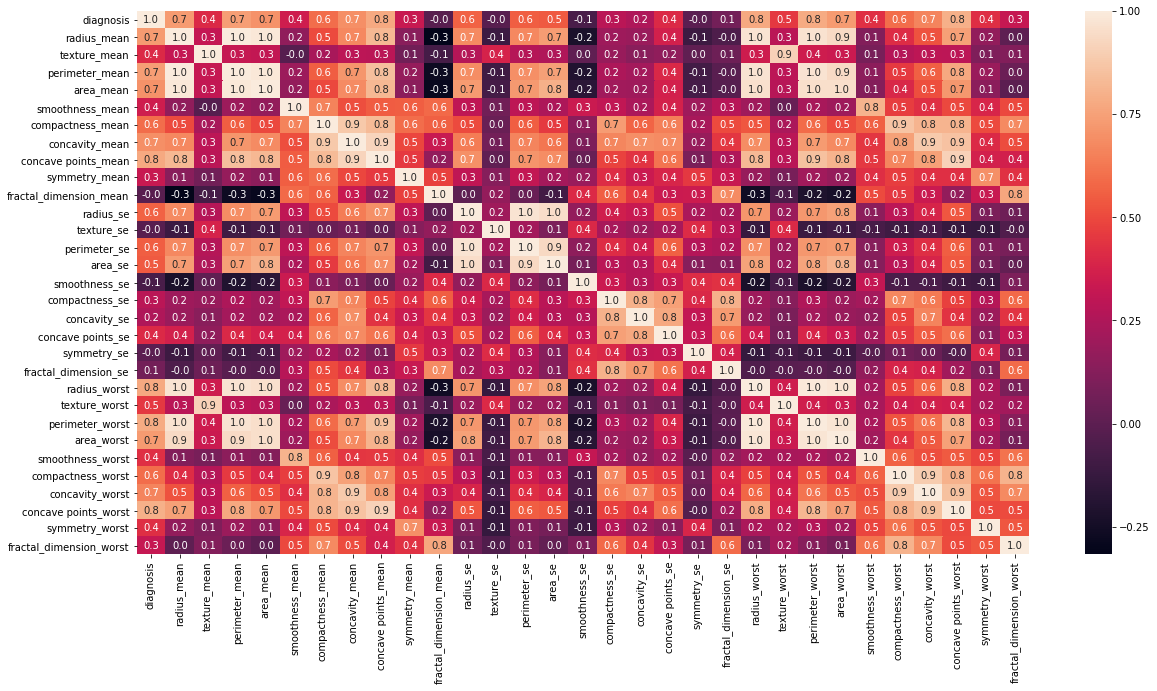

In [6]:
fig, axes = plt.subplots(figsize=(20, 10))
sns.heatmap(df.corr(), ax=axes, annot=True, fmt='.1f')

#### Select features and target columns


Index(['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')
diagnosis


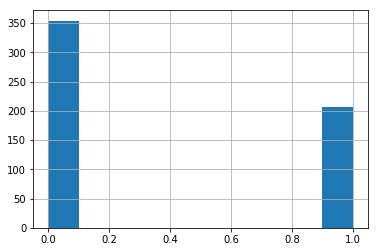

In [7]:
features = df.columns[1:]
print(features)
target = df.columns[0]
print(target)

df[target].hist()

X = df[features]
y = df[target]



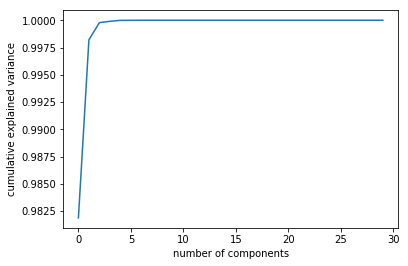

In [8]:
pca = PCA().fit(df[features])
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

#### Scale and visualize using PCA

In [9]:

print(diagnosis_encoder.classes_)

scaler = StandardScaler()
scaler.fit(X)

X_scaled = scaler.transform(X)
y_train = y

['B' 'M']


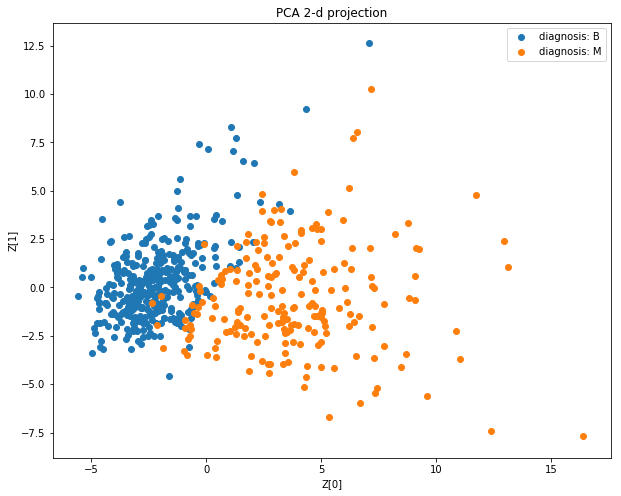

In [10]:
pca_2d = PCA(n_components=4)
Z_2d = pca_2d.fit_transform(X_scaled)

fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(Z_2d[y_train==0, 0], Z_2d[y_train==0, 1], label='diagnosis: B')
ax.scatter(Z_2d[y_train==1, 0], Z_2d[y_train==1, 1], label='diagnosis: M')
ax.set(title='PCA 2-d projection', xlabel='Z[0]', ylabel='Z[1]')
ax.legend()

### C. Train test split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=.20, random_state=42)

In [12]:
Z_train = X_train
Z_test = X_test

### D. Train models

- 2 types of models to train
  -  Using cross_validate to select the best scoring model based on validation score

In [13]:
from sklearn.model_selection import learning_curve, cross_validate
def plot_learning_curve(model, name=''):
    # 3-fold cross validation to get learning curve R2 scores
    # using default train_sizes
    train_sizes, train_scores, val_scores = learning_curve(model,
                                                           Z_train, 
                                                           y_train, cv=5)

    # plot learning curve:
    #   plot train_scores vs. train_sizes
    #   plot val_scores vs. train_sizes
    # train_sizes is the number of training samples used for training

    fig, ax = plt.subplots()
    ax.plot(train_sizes, train_scores.mean(axis=1),
            label='train') # average for 5-folds
    ax.plot(train_sizes, val_scores.mean(axis=1),
            label='val')
#    plt.axhline(y=max(val_scores[0]), color='r', linestyle='-')

    ax.legend()
    ax.set(title='Learning curve ' + name, xlabel='Train size', ylabel='Accuracy')
    return train_sizes, train_scores, val_scores



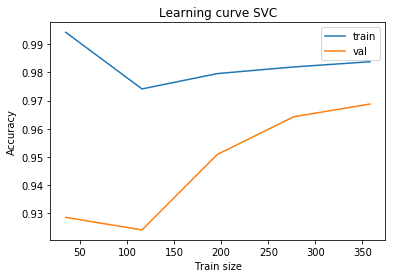

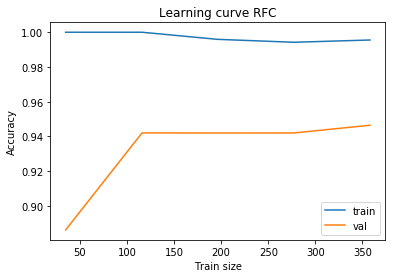

In [14]:
# SVC => Cross Validate
model_scv = SVC(max_iter=5000, tol=1e-3,
                     random_state=8, gamma='scale')
scores = cross_validate(model_scv, Z_train, y_train, cv=5,
                        return_train_score=True, return_estimator=True)
# - learning curve (plot for overfit / underfit)
train_sizes, train_scores, val_scores = plot_learning_curve(model_scv, 'SVC')

#print("SVC validation scores: ", max(val_scores[0]))

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, RandomForestClassifier, ExtraTreesRegressor, ExtraTreesClassifier


# RandomForestClassifier => Cross Validate
model_rfc = RandomForestClassifier(n_estimators=10, random_state=8)
scores = cross_validate(model_rfc, Z_train, y_train, cv=5,
                        return_train_score=True, return_estimator=True)
# - learning curve (plot for overfit / underfit)
train_sizes, train_scores, val_scores = plot_learning_curve(model_rfc, 'RFC')
#print("RandomForestClassifier validation scores: ", max(val_scores[0]))





## Evaluation Metrics

Determine which model you selected performs the best

### SVC

- Get Predictions from the test set from train_test_split
- Generate classification_report
- Generate confusion_matrix

In [15]:
model_scv.fit(Z_train, y_train)
y_pred = model_scv.predict(Z_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.99        69
           1       1.00      0.95      0.98        43

   micro avg       0.98      0.98      0.98       112
   macro avg       0.99      0.98      0.98       112
weighted avg       0.98      0.98      0.98       112



[Text(33.0, 0.5, 'Truth'), Text(0.5, 15.0, 'Prediction')]

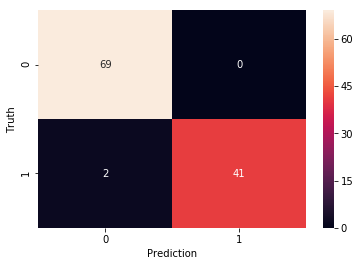

In [16]:
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
ax.set(xlabel='Prediction', ylabel='Truth')

### RandomForestClassifier

- Get Predictions from the test set from train_test_split
- Generate classification_report
- Generate confusion_matrix

In [17]:
model_rfc.fit(Z_train, y_train)
y_pred = model_rfc.predict(Z_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96        69
           1       0.97      0.88      0.93        43

   micro avg       0.95      0.95      0.95       112
   macro avg       0.95      0.93      0.94       112
weighted avg       0.95      0.95      0.95       112



[Text(33.0, 0.5, 'Truth'), Text(0.5, 15.0, 'Prediction')]

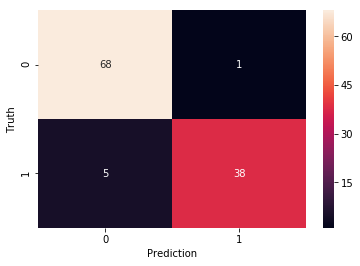

In [18]:
ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
ax.set(xlabel='Prediction', ylabel='Truth')

### Selected Model ( SVC )

- SVC model performs better than RandomForestClassifier considering F-score and FP.
- FP represents the Model has predicted NO cancer but acutally the paients has cancer. For Cancer detection, it is better to choose a model which has minimum FP.
- SVC model was chosen as the FP value is only 2 compared to RandomForestClassifier which produced 5 FP.


## Prediction

  - Use SVC to predict using prediction_data.csv.
  - print out the prediction (malignant or benign).

In [19]:
df = pd.read_csv('prediction_data.csv')

df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 32 columns):
id                         4 non-null int64
diagnosis                  4 non-null object
radius_mean                4 non-null float64
texture_mean               4 non-null float64
perimeter_mean             4 non-null float64
area_mean                  4 non-null float64
smoothness_mean            4 non-null float64
compactness_mean           4 non-null float64
concavity_mean             4 non-null float64
concave points_mean        4 non-null float64
symmetry_mean              4 non-null float64
fractal_dimension_mean     4 non-null float64
radius_se                  4 non-null float64
texture_se                 4 non-null float64
perimeter_se               4 non-null float64
area_se                    4 non-null float64
smoothness_se              4 non-null float64
compactness_se             4 non-null float64
concavity_se               4 non-null float64
concave points_se          4

In [20]:
#print(df.dtypes)
df['diagnosis'] = diagnosis_encoder.transform(df['diagnosis'])
#print(df.head())
X = df[features]
y_test = df[target]

Z = scaler.transform(X)
y_pred = model_rfc.predict(Z)
#print(diagnosis_encoder.inverse_transform(y_pred))
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         3

   micro avg       1.00      1.00      1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



In [21]:
print("Prediction Accuracy: ", accuracy_score(y_test, y_pred)*100, '%' )
    
df = pd.read_csv('prediction_data.csv')
df['Predicted'] = diagnosis_encoder.inverse_transform(y_pred)

print()
print(df.loc[:,['id', 'diagnosis','Predicted']])


Prediction Accuracy:  100.0 %

       id diagnosis Predicted
0  926682         M         M
1  926954         M         M
2  927241         M         M
3   92751         B         B


In [22]:
#End of this Analysis